In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.signal as sp
import numpy.random as rnd

%matplotlib inline

In [2]:
def generalizedPlant(A,B,C,D,Cov,dt):
    CovChol = la.cholesky(Cov,lower=True)
    NumStates = len(A)

    B1 = CovChol[:NumStates,:]
    B2 = B

    Bbig = np.hstack((B1,B2))

    D1 = CovChol[NumStates:,:]
    D2 = D
    Dbig = np.hstack((D1,D2))

    P = (A,Bbig,C,Dbig,dt)
    return P

In [3]:
def block2mat(Mblock):
    Nr,Nc,bh,bw = Mblock.shape
    M = np.zeros((Nr*bh,Nc*bw))
    for k in range(Nr):
        M[k*bh:(k+1)*bh] = np.hstack(Mblock[k])
        
    return M

def blockTranspose(M,blockHeight,blockWidth):
    """
    Switches block indices without transposing the blocks
    """
    r,c = M.shape
    Nr = r / blockHeight
    Nc = c / blockWidth
    Mblock = np.zeros((Nr,Nc,blockHeight,blockWidth))
    for i in range(Nr):
        for j in range(Nc):
            Mblock[i,j] = M[i*blockHeight:(i+1)*blockHeight,j*blockWidth:(j+1)*blockWidth]
            
            
    MtBlock = np.zeros((Nc,Nr,blockHeight,blockWidth))
    for i in range(Nr):
        for j in range(Nc):
            MtBlock[j,i] = Mblock[i,j]
            
    return block2mat(MtBlock)
            

In [4]:
def blockHankel(Hleft,Hbot=None,blockHeight=1):
    """
    Compute a block hankel matrix from the left block matrix and the optional bottom block matrix
    
    Hleft is a matrix of dimensions (NumBlockRows*blockHeight) x blockWidth
    
    Hbot is a matrix of dimensions blockHeight x (NumBlockColumns*blockWidth)
    """
    
    blockWidth = Hleft.shape[1]
    if Hbot is None:
        Nr = len(Hleft) / blockHeight
        Nc = Nr
    else:
        blockHeight = len(Hbot)
        Nr = len(Hleft) / blockHeight
        Nc = Hbot.shape[1] / blockWidth
        
    LeftBlock = np.zeros((Nr,blockHeight,blockWidth))
    
    for k in range(Nr):
        LeftBlock[k] = Hleft[k*blockHeight:(k+1)*blockHeight]
        
    
        
    # Compute hankel matrix in block form
    MBlock = np.zeros((Nr,Nc,blockHeight,blockWidth))
    
    for k in range(np.min([Nc,Nr])):
        # If there is a bottom block, could have Nc > Nr or Nr > Nc
        MBlock[:Nr-k,k] = LeftBlock[k:]
        
        
    if Hbot is not None:
        BotBlock = np.zeros((Nc,blockHeight,blockWidth))
        for k in range(Nc):
            BotBlock[k] = Hbot[:,k*blockWidth:(k+1)*blockWidth]
            
        for k in range(np.max([1,Nc-Nr]),Nc):
            MBlock[Nr-Nc+k,Nc-k:] = BotBlock[1:k+1]
            
    
    # Convert to a standard matrix
    M = block2mat(MBlock)
        
    return M

In [5]:
def getHankelMatrices(x,NumRows,NumCols,blockWidth=1):
    # For consistency with conventions in Van Overschee and De Moor 1996, 
    # it is assumed that the signal at each time instant is a column vector
    # and the number of samples is the number of columns.
    
    bh = len(x)
    bw = 1
    xPastLeft = blockTranspose(x[:,:NumRows],blockHeight=bh,blockWidth=bw)
    XPast = blockHankel(xPastLeft,x[:,NumRows-1:NumRows-1+NumCols])
    
    xFutureLeft = blockTranspose(x[:,NumRows:2*NumRows],blockHeight=bh,blockWidth=bw)
    XFuture = blockHankel(xFutureLeft,x[:,2*NumRows-1:2*NumRows-1+NumCols])
    return XPast,XFuture

In [39]:
def N4SID(u,y,NumRows,NumCols,NSig):
    NumInputs = u.shape[0]
    NumOutputs = y.shape[0]
    

    UPast,UFuture = getHankelMatrices(u,NumRows,NumCols)
    YPast,YFuture = getHankelMatrices(y,NumRows,NumCols)
    Data = np.vstack((UPast,UFuture,YPast))
    L = la.lstsq(Data.T,YFuture.T)[0].T
    Z = np.dot(L,Data)
    DataShift = np.vstack((UPast,UFuture[NumInputs:],YPast))
    LShift = la.lstsq(DataShift.T,YFuture[NumOutputs:].T)[0].T
    ZShift = np.dot(LShift,DataShift)

    L1 = L[:,:NumInputs*NumURows]
    L3 = L[:,2*NumInputs*NumURows:]

    LPast = np.hstack((L1,L3))
    DataPast = np.vstack((UPast,YPast))

    U, S, Vt = la.svd(np.dot(LPast,DataPast))
    
    Sig = np.diag(S[:NSig])
    SigRt = np.diag(np.sqrt(S[:NSig]))
    Gamma = np.dot(U[:,:NSig],SigRt)
    GammaLess = Gamma[:-NumOutputs]

    GammaPinv = la.pinv(Gamma)
    GammaLessPinv = la.pinv(GammaLess)

    GamShiftSolve = la.lstsq(GammaLess,ZShift)[0]


    GamSolve = la.lstsq(Gamma,Z)[0]
    GamData = np.vstack((GamSolve,UFuture))

    GamYData = np.vstack((GamShiftSolve,YFuture[:NumOutputs]))

    K = la.lstsq(GamData.T,GamYData.T)[0].T
    rho = GamYData - np.dot(K,GamData)

    AID = K[:NSig,:NSig]
    CID = K[NSig:,:NSig]
    

    CovID = np.dot(rho,rho.T) / NumCols
    
    # Now we must construct B and D

    AC = np.vstack((AID,CID))
    L = np.dot(AC,GammaPinv)

    M = np.zeros((NSig,NumRows*NumOutputs))
    M[:,NumOutputs:] = GammaLessPinv
    Mleft = blockTranspose(M,NSig,NumOutputs)
    LtopLeft = blockTranspose(L[:NSig],NSig,NumOutputs)
    NTop = blockHankel(Mleft,blockHeight=NSig) - blockHankel(LtopLeft,blockHeight=NSig)

    LbotLeft = blockTranspose(L[NSig:],NumOutputs,NumOutputs)
    NBot= -blockHankel(LbotLeft,blockHeight=NumOutputs)
    NBot[:NumOutputs,:NumOutputs] = NBot[:NumOutputs,:NumOutputs] + np.eye(NumOutputs)

    N = np.dot(np.vstack((NTop,NBot)),la.block_diag(np.eye(NumOutputs),GammaLess))
    
    KsTop = np.zeros((NSig*NumRows,NumInputs))
    KsBot = np.zeros((NumOutputs*NumRows,NumInputs))

    Kr = K[:,NSig:]
    for k in range(NumRows):
        KsTop[k*NSig:(k+1)*NSig] = Kr[:NSig,k*NumInputs:(k+1)*NumInputs]
        KsBot[k*NumOutputs:(k+1)*NumOutputs] = Kr[NSig:,k*NumInputs:(k+1)*NumInputs]
    
    Ks = np.vstack((KsTop,KsBot))

    DB = la.lstsq(N,Ks)[0]

    BID = DB[NumOutputs:]
    DID = DB[:NumOutputs]
    
    return AID,BID,CID,DID,CovID,S



In [77]:
# Define the plant
dt = .1
k1 = 1.
k2 = 2.
c1 = 2.
c2 = 2.
m1 = 1.
m2 = 1.
Kmat = np.array([[k1+k2,-k2],
                 [-k2,k2]])
Cmat = np.diag([c1,c2])

Mmat  = np.diag([m1,m2])


Ac = np.zeros((4,4))

Ac[:2,2:] = np.eye(2)
Ac[2:,:2] = -la.solve(Mmat,Kmat,sym_pos=True)
Ac[2:,2:] = -la.solve(Mmat,Cmat,sym_pos=True)
A = np.eye(4) + dt * Ac

Bc = np.zeros((4,2))
Bc[2:] = la.inv(Mmat)

Bc = np.zeros((4,1))
Bc[2,0] = 1.

B = dt * Bc
C = np.zeros((2,4))
C[:,:2] = np.eye(2)

NumInputs = B.shape[1]
NumOutputs = C.shape[0]

D = np.zeros((NumOutputs,NumInputs))

NumStates = len(A)
NumOutputs,NumInputs = D.shape

Q = .1 * np.eye(NumStates) * dt 
S = np.zeros((NumStates,NumOutputs))
R = .1 * np.eye(NumOutputs) / dt

CovTop = np.hstack((Q,S))
CovBot = np.hstack((S.T,R))
Cov = np.vstack((CovTop,CovBot))

P = generalizedPlant(A,B,C,D,Cov,dt)

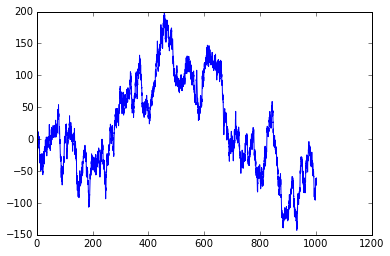

In [78]:
# Generate an input to the plant.
# use inpdendent OU processes
theta = .01
AU = (1- dt * theta) * np.eye(NumInputs)
BU = 10 * np.eye(NumInputs) * np.sqrt(dt)
CU = np.eye(NumInputs)
DU = np.zeros((NumInputs,NumInputs)) / np.sqrt(dt)
# Sampling rate of 1
USys = (AU,BU,CU,DU,dt)
NumURows = 10
NumUCols = 10000
NumU = 2 * NumURows + NumUCols - 1
Time = np.arange(NumU)
uu = rnd.randn(NumU,NumInputs)
# u is the actual input
tu,u,xu = sp.dlsim(USys,uu)
plt.plot(tu,u.squeeze())

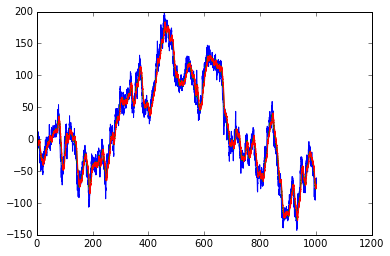

In [79]:
# Simulate the plant with the generated input as well as noise
w = rnd.randn(NumU,NumStates+NumOutputs)
bigU = np.hstack((w,u))
tout,y,xout = sp.dlsim(P,bigU)
plt.plot(tout,u)
plt.plot(tout,y)

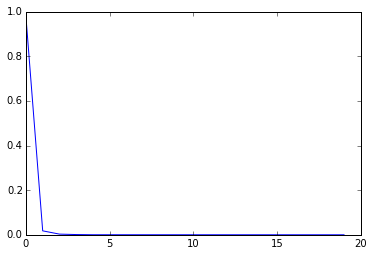

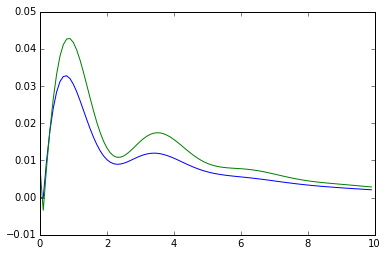

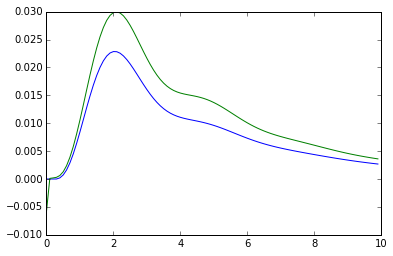

In [80]:
# Identify matrices using the N4SID algorithm
AID,BID,CID,DID,CovID,S = N4SID(u.T,y.T,NumURows,NumUCols,4)
# For conistency with the Subspace ID literature, 
# we transpose the signals so that each input and output instance is a column vector
# This is opposite from the lsim convention

# Check the singular values
plt.plot(S / S.sum())

# Check how the computed impulse resonse compares.
plt.figure()
NhSteps = 100
tout,hTrue = sp.dimpulse((A,B,C,D,dt),t=dt * np.arange(NhSteps))
tout,hID = sp.dimpulse((AID,BID,CID,DID,dt),t=dt*np.arange(NhSteps))
for i in range(NumOutputs):
    for j in range(NumInputs):
        plt.figure()
        plt.plot(tout,hTrue[j][:,i])
        plt.plot(tout,hID[j][:,i])

In [81]:
print Cov
print CovID

[[ 0.01  0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.    0.    0.    0.  ]
 [ 0.    0.    0.01  0.    0.    0.  ]
 [ 0.    0.    0.    0.01  0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]]
[[  9.87666310e-08  -5.58287486e-07  -1.35752714e-06  -1.09987502e-06
   -2.52258665e-06   5.82341385e-07]
 [ -5.58287486e-07   4.14302320e-06   5.92506084e-06   1.06435726e-05
    1.57830929e-05   3.54023245e-05]
 [ -1.35752714e-06   5.92506084e-06   2.70489167e-05   1.59600534e-05
    1.04346721e-04  -9.01629424e-05]
 [ -1.09987502e-06   1.06435726e-05   1.59600534e-05   4.71251130e-05
    1.52001839e-04   1.43553649e-04]
 [ -2.52258665e-06   1.57830929e-05   1.04346721e-04   1.52001839e-04
    1.09507313e+00   1.21019129e-02]
 [  5.82341385e-07   3.54023245e-05  -9.01629424e-05   1.43553649e-04
    1.21019129e-02   1.12945088e+00]]


In [73]:
NumInputs

2